# Étude sur les facteurs qui déterminent la santé des enfants aux États-Unis

# Importation des bibliothèques

In [1]:
# -q : quiet --> réduction des messages
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Bibliothèques

import s3fs # pour récupérer les fichiers de l'espace de stockage S3
import pandas as pd # pour la gestion des dataframes
import geopandas as gpd # pour la gestion des données géographiques (fichiers .shp)
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer # pour l'imputation des données manquantes
from sklearn.decomposition import PCA # pour l'analyse en Composantes Principales
from sklearn.preprocessing import StandardScaler # pour la normalisation des dataframes

import folium # création de cartes interactives
from folium.features import Choropleth
import branca # pour la partie échelle de la carte
import numpy as np # pour la gestion des dataframes
import os # pour les lectures / écritures en S3
import prince # pour l'analyse en Composantes Multiples
import seaborn as sns # pour la création de graphiques
from matplotlib.patches import Ellipse # pour la création de graphiques
from scipy.stats import norm, kendalltau # pour des statistiques
import statsmodels.api as sm
from functools import reduce

# pour des fenêtres interactives avec l'utilisateur
import ipywidgets as widgets 
from IPython.display import display 
from IPython.display import clear_output

# Libraries propres pour faciliter la lecture du notebook
import script.clean_data as cd
import script.analyse_data as ad
import script.model as model

# Récupération des bases de données

In [3]:
# Maximum 15 secondes

# (depuis le stockage S3 d'un membre du groupe via le dossier public diffusion)
# Stocker les fichiers dans un dossier data/nsch

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

chemin_lecture_nsch = "inacampan/diffusion/Determinants_of_children-s_health/NSCH/"
chemin_ecriture_nsch = "data/nsch/"

# Lecture des fichiers des bases de données
dfs = cd.lecture_fichier_sas(fs, chemin_lecture_nsch, chemin_ecriture_nsch)

# récupérer le guide technique du questionnaire
# ce fichier inclut le nom de la variable, la question qu'elle encode, l'année du questionnaire
# mais également des notes pour la compréhension de la base de données initiale

guide = cd.lecture_fichier_csv(fs, f"{chemin_lecture_nsch}NSCH_Dictionary.csv", f"{chemin_ecriture_nsch}NSCH_Dictionary.csv")

# Élément de précaution : GUIDE contient plusieurs index de même nom
# mais les caractéristiques ne sont pas identiques

In [4]:
# Maximum 2 secondes

# Récupérer les fichiers associés au shapefile - utiles pour les cartes (depuis le stockage S3 d'un membre du groupe)

chemin_lecture_map = "inacampan/diffusion/Determinants_of_children-s_health/Map/"
chemin_ecriture_map = "data/map/"

# lecture du fichier
gdf = cd.lecture_fichier_shapefile(fs, chemin_lecture_map, chemin_ecriture_map)

In [5]:
# Maximum 2 secondes
# Récuperer les données économiques - fichier csv
chemin_lecture_eco = "inacampan/diffusion/Determinants_of_children-s_health/Economic/"
chemin_ecriture_eco = "data/economic/"

# lecture du fichier
gdp = cd.lecture_fichier_csv(fs, 
                             f"{chemin_lecture_eco}SASUMMARY__ALL_AREAS_1998_2024.csv", 
                             f"{chemin_ecriture_eco}SASUMMARY__ALL_AREAS_1998_2024.csv")

In [6]:
# Maximum 2 secondes
# Rapport annuel 2024 sur des indicateurs de santé --- Les données d'America's Health Rankings
annual_report = cd.lecture_fichier_csv(fs, 
                                       f"{chemin_lecture_nsch}2024-annual-report-report-data-all-states.csv",
                                       f"{chemin_ecriture_nsch}2024-annual-report-report-data-all-states.csv", 
                                       latin_encoding=True)

# Description des données et statistiques descriptives

Conformément au site qui héberge les bases de données NSCH, le questionnaire de présélection (NSCH-S1) déterminait si l’adresse représentait une résidence occupée et s’il y avait des enfants admissibles âgés de 0 à 17 ans vivant à cette adresse échantillonnée.

Le questionnaire thématique ("topical") comprenait des questions détaillées portant sur un enfant sélectionné au hasard dans le ménage. Les ménages recevaient l’un des trois questionnaires thématiques spécifiques à l’âge, en fonction de l’âge de l’enfant échantillonné : 
* NSCH-T1 (ou T1) pour les enfants âgés de 0 à 5 ans,
* NSCH-T2 (ou T2) pour les enfants âgés de 6 à 11 ans, ou
* NSCH-T3 (ou T3) pour les enfants âgés de 12 à 17 ans.

Le type du questionnaire est codé dans la variable ```FORMTYPE```.
Dans notre projet nous regardons uniquement le questionnaire "topical", qui contient environ 400 variables. Nous gardons les questionnaires des années 2024, 2023, 2022, 2021. Les illustrations sont faites sur l'année 2023.

In [7]:
df = dfs["2023"] # regardons d'abord l'année 2023
df.describe()

,HEIGHT,TOTKIDS_R,TENURE,HHLANGUAGE,SC_AGE_YEARS,SC_SEX,K2Q35A_1_YEARS,BIRTH_MO,BIRTH_YR,K6Q41R_STILL,...,HHCOUNT_IF,HIGRADE,HIGRADE_TVIS,FPL_I1,FPL_I2,FPL_I3,FPL_I4,FPL_I5,FPL_I6,FWC
count,32319.000000,55162.000000,55162.000000,54862.000000,55162.000000,55162.000000,1971.000000,54770.000000,54675.000000,18118.000000,...,55162.000000,55162.000000,55162.000000,55162.000000,55162.000000,55162.000000,55162.000000,55162.000000,55162.000000,55162.000000
mean,151.687657,1.876690,1.455187,1.126135,8.339563,1.486422,4.868087,6.613255,2014.314092,1.884204,...,0.031761,2.829393,3.485606,287.280537,287.401998,287.531362,288.364091,287.652804,287.905080,1308.472653
std,20.522720,0.870582,0.787676,0.439835,5.303088,0.499820,3.478265,3.404391,5.324464,0.319990,...,0.175365,0.436074,0.799796,124.920459,124.878680,124.957976,124.475651,124.808909,124.524807,2334.642676
min,93.980000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2005.000000,1.000000,...,0.000000,1.000000,1.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,11.006690
25%,134.620000,1.000000,1.000000,1.000000,4.000000,1.000000,2.000000,4.000000,2009.000000,2.000000,...,0.000000,3.000000,3.000000,179.000000,179.000000,179.000000,182.000000,179.000000,181.000000,263.179394
50%,154.940000,2.000000,1.000000,1.000000,8.000000,1.000000,3.000000,7.000000,2015.000000,2.000000,...,0.000000,3.000000,4.000000,337.000000,337.000000,337.000000,337.500000,337.000000,337.000000,639.147322
75%,167.630000,2.000000,2.000000,1.000000,13.000000,2.000000,6.000000,10.000000,2019.000000,2.000000,...,0.000000,3.000000,4.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,1416.809570
max,211.050000,4.000000,4.000000,3.000000,17.000000,2.000000,15.000000,12.000000,2023.000000,2.000000,...,1.000000,3.000000,4.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,54078.402188


In [8]:
# La base de données de 2023 est dense, avec un total de 452 de variables sur 55162 individus (à travers les États-Unis).
# Sur l'ensemble des enfants dans l'échantillon : 
# (i) 21524 sont âgés de 0 à 5 ans,
# (ii) 18397 sont âgés de 6 à 11 ans et 
# (iii) 15241 sont âgés de 11 à 17 ans.

print(df["FORMTYPE"].value_counts())
print(df["FIPSST"].value_counts()[:5])

FORMTYPE
T1    21524
T3    18397
T2    15241
Name: count, dtype: int64
FIPSST
06    4696
20    2805
27    2400
22    2093
39    1735
Name: count, dtype: int64


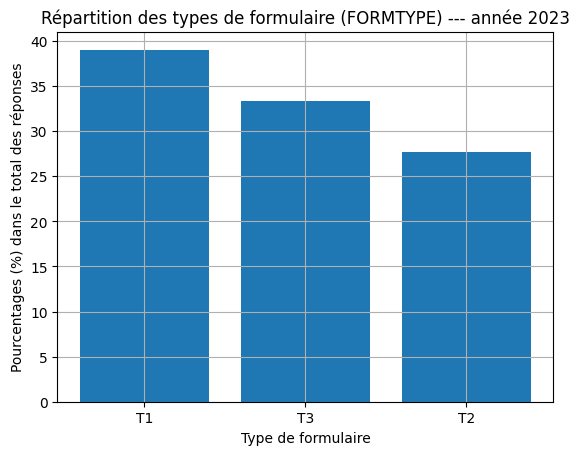

In [9]:
form_counts = df["FORMTYPE"].value_counts()
form_percent = form_counts / form_counts.sum() * 100

# Graphique bar plot

plt.bar(form_percent.index, form_percent.values)
plt.title("Répartition des types de formulaire (FORMTYPE) --- année 2023")
plt.ylabel("Pourcentages (%) dans le total des réponses")
plt.xlabel("Type de formulaire")
plt.grid()
plt.show()

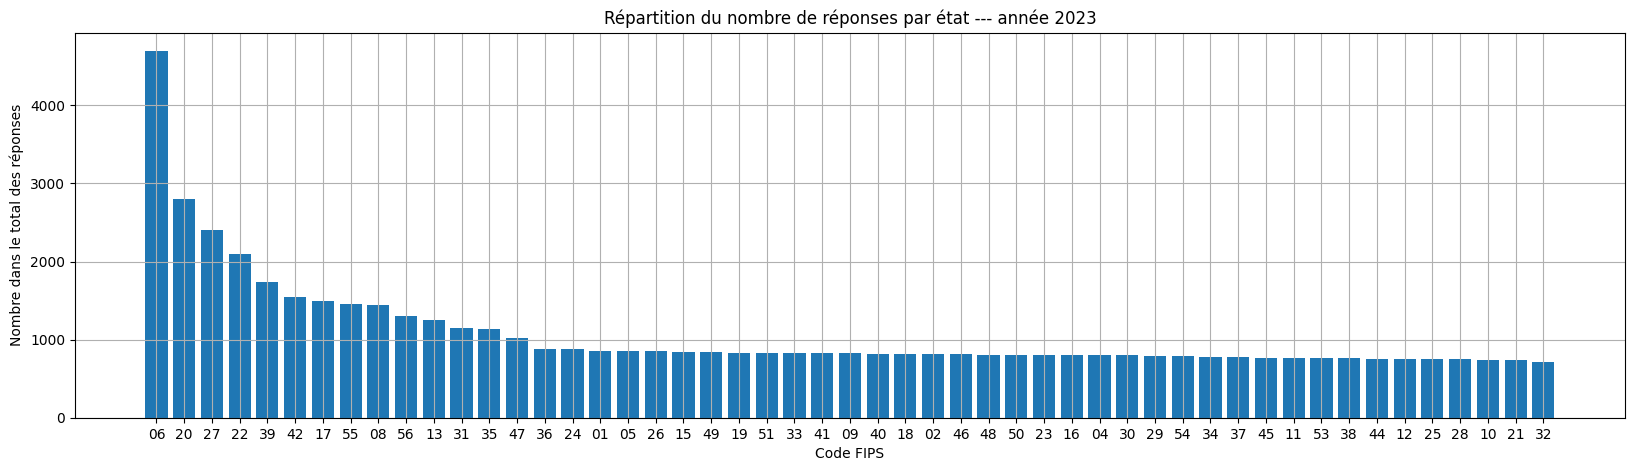

In [10]:
code_counts = df["FIPSST"].value_counts()

# Graphique bar plot

plt.figure(figsize=(20, 5))
plt.bar(code_counts.index, code_counts.values)
plt.title("Répartition du nombre de réponses par état --- année 2023")
plt.ylabel("Nombre dans le total des réponses")
plt.xlabel("Code FIPS")
plt.grid()
plt.show()

L’IMC (Indice de Masse Corporelle) permet de classer les individus selon leur corpulence et d’identifier des tendances générales au sein d’une population.

Dans le questionnaire NSCH, les questions sur la taille et le poids des enfants ne sont posées qu’aux enfants de plus de 5 ans. Ainsi, pour presque la moitié de notre échantillon, ces informations ne sont pas disponibles, ce qui limite l’analyse de l’IMC pour l’ensemble de la population étudiée.

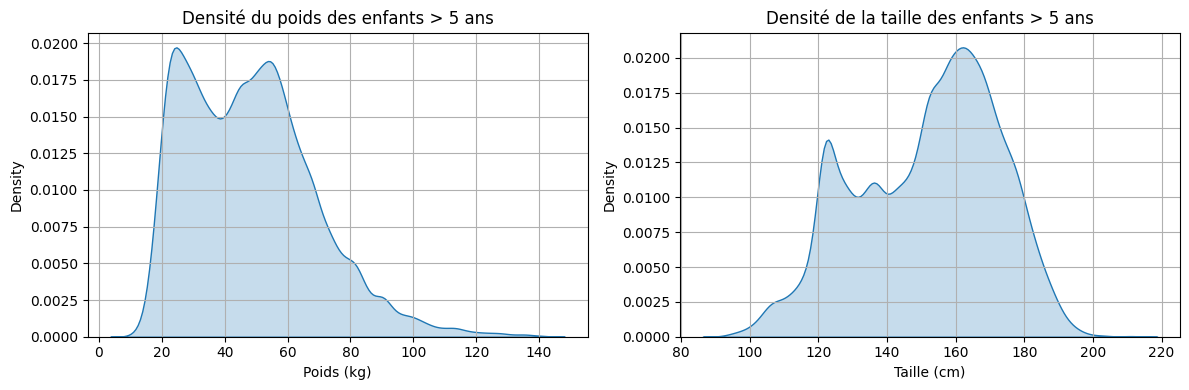

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 ligne, 2 plot

# pour la variable poids

sns.kdeplot(data=df, x="WEIGHT", fill=True, ax=axes[0])
axes[0].set_xlabel("Poids (kg)")
axes[0].set_title("Densité du poids des enfants > 5 ans")
axes[0].grid(True)

# pour la variable taille

sns.kdeplot(data=df, x="HEIGHT", fill=True, ax=axes[1])
axes[1].set_xlabel("Taille (cm)")
axes[1].set_title("Densité de la taille des enfants > 5 ans")
axes[1].grid(True)

plt.tight_layout() 
plt.show()

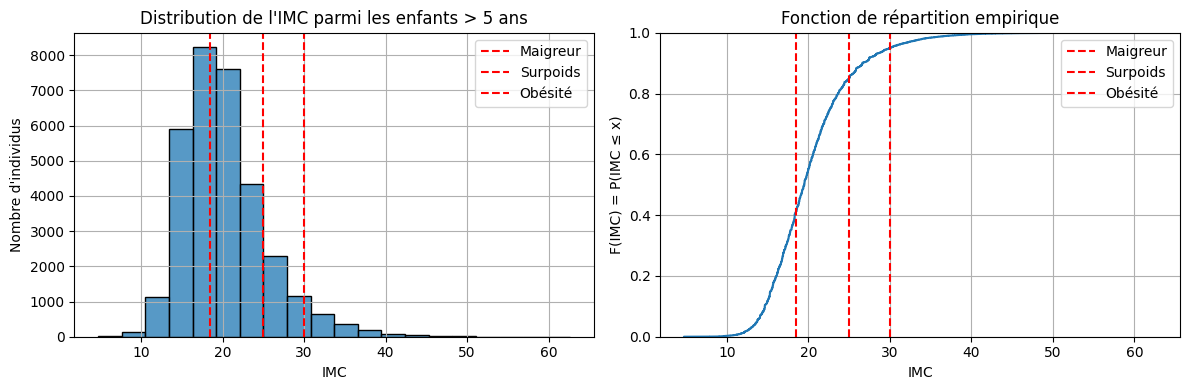

In [12]:
imc = (df["WEIGHT"] / ((df["HEIGHT"] / 100) ** 2)).dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 ligne, 2 plot

sns.histplot(imc, bins=20, ax=axes[0])
for v, label in [(18.5, "Maigreur"), (25, "Surpoids"), (30, "Obésité")]:
    axes[0].axvline(v, linestyle="--", color="red", label=label)

axes[0].set_xlabel("IMC")
axes[0].set_ylabel("Nombre d'individus")
axes[0].set_title("Distribution de l'IMC parmi les enfants > 5 ans")
axes[0].legend()
axes[0].grid(True)

sns.ecdfplot(imc, ax=axes[1])
for v, label in [(18.5, "Maigreur"), (25, "Surpoids"), (30, "Obésité")]:
    axes[1].axvline(v, linestyle="--", color="red", label=label)

axes[1].set_xlabel("IMC")
axes[1].set_ylabel("F(IMC) = P(IMC ≤ x)")
axes[1].set_title("Fonction de répartition empirique")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()  
plt.show()

On regarde le pourcentage de valeurs manquantes par colonne, par ordre décroissant.
On observe des taux de valeurs manquantes très élevés pour certaines questions qui ne sont posées que dans des cas très spécifiques et qui dépendent d’une réponse précédente.

Par exemple, pour la variable ```CYSFIB_SCREEN``` (avec un taux de 99.94% de valeurs manquantes), celle-ci encode la question :

**Was this condition identified through a blood test done shortly after birth? … These tests are sometimes called newborn screening.** Cette question est ignorée si ```CYSTFIB = 2```. La variable ```CYSFIB``` a un taux très faible (0.19%) de valeurs manquantes et parmi les valeurs prises, ```CYSFIB!=2``` dans seulement 30 questionnaires.

Pour les variables ```DIABETES_DESC``` et ```DIABETES_CURR```, les questions qu'elles encodent sont ignorées dès lorsque ```DIABETES = 2``` (ce qui regroupe seulement 40 questionnaires).

In [13]:
missing_values = df.isna().mean().sort_values(ascending=False) * 100

print("Valeurs manquantes en pourcentage par colonne\n",
    missing_values)
print("Nombre de colonnes avec au moins 50% de valeurs manquantes\n",(missing_values >= 50).sum())

# Illustration de l'exemple de CYSTFIB et DIABETES
print("---------------------------------")
print("Informations sur la variable CYSTFIB_SCREEN : ", guide[guide["Variable"] == "CYSTFIB_SCREEN"]["Universe"].iloc[0], "\n",
    guide[guide["Variable"] == "CYSTFIB"]["Question"].iloc[0])
print("Valeurs manquantes pour la variable CYSTFIB : \n",
    (df["CYSTFIB"].isna().mean() * 100).round(2), "%")
print(df["CYSTFIB"].value_counts())

print("---------------------------------")
print("Informations sur la variable DIABETES_CURR : ", guide[guide["Variable"] == "DIABETES_CURR"]["Universe"].iloc[0], "\n",
    guide[guide["Variable"] == "DIABETES"]["Question"].iloc[0])
print("Valeurs manquantes pour la variable DIABETES : \n",
    (df["DIABETES"].isna().mean() * 100).round(2), "%")
print(df["DIABETES"].value_counts())

Valeurs manquantes en pourcentage par colonne
 CYSTFIB_SCREEN    99.949240
DIABETES_DESC     99.945615
DIABETES_CURR     99.922048
K2Q38C            99.789710
LIVEUSA_MO        99.778833
                    ...    
FPL_I3             0.000000
FPL_I4             0.000000
FPL_I5             0.000000
FPL_I6             0.000000
FWC                0.000000
Length: 456, dtype: float64
Nombre de colonnes avec au moins 50% de valeurs manquantes
 180
---------------------------------
Informations sur la variable CYSTFIB_SCREEN :  Skip if CYSTFIB=2 
 Header: Has a doctor or other health care provider EVER told you that this child has......Cystic Fibrosis?
Valeurs manquantes pour la variable CYSTFIB : 
 0.19 %
CYSTFIB
2.0    55025
1.0       30
Name: count, dtype: int64
---------------------------------
Informations sur la variable DIABETES_CURR :  Skip if DIABETES=2 
 Header: Has a doctor or other health care provider EVER told you that this child has......Type 2 Diabetes?
Valeurs manquantes pou

## Choix des variables d'intérêt

Dans le guide, les variables sont classées dans plusieurs grandes catégories, en fonction de la question de recherche et également de la base de données associée. En vue de notre base de données, on peut garder uniquement les variables de type "Topical" et "Operational" (colonne "Source").

In [14]:
guide = guide[guide["Source"].isin({"Topical", "Operational"})]

years = {"2021", "2022", "2023", "2024"}

# On garde uniquement des variables qui sont communes aux quatre dataset NSCH
guide = guide[guide["Survey Years"].apply(
    lambda x: years <= set(y.strip() for y in str(x).split(","))
)]

# Cela réduit la base à 318 variables communes entre les bases de données
# Nettoyer les dataframes NSCH avec cette contrainte, en rajoutant le code de l'état de résidence
# comme variable admissible, ainsi que la taille et le poids de l'enfant.

variables_com = set(guide["Variable"])
variables_com = variables_com | {"FIPSST", "WEIGHT", "HEIGHT"}

for year in ["2023", "2022", "2021", "2024"]:
    df = dfs[year]
    df = df.loc[:, df.columns.isin(variables_com)]
    dfs[year] = df

In [15]:
counts = guide.groupby(["Source", "Topic"])["Variable"].count().reset_index(name="count")
print("Nombre de variables par groupe de (Source, Topic)\n",counts.to_string())

Nombre de variables par groupe de (Source, Topic)
          Source                            Topic  count
0   Operational                Data Quality Flag      1
1   Operational                        Geography      4
2   Operational                  Imputation Flag     10
3   Operational                      Operational      3
4   Operational                           Weight      3
5       Topical           A. This Child's Health     83
6       Topical       B. This Child as an Infant     19
7       Topical          C. Health Care Services     61
8       Topical         D. Health Care Providers     25
9       Topical     E. Health Insurance Coverage     13
10      Topical         F. Providing Health Care      8
11      Topical       G. Learning and Activities     33
12      Topical      H. About You and This Child     19
13      Topical     I. Your Family and Household     36
14      Topical  J. About You/Child's Caregivers     18
15      Topical         K. Household Information     

Liste de nos variables de santé générale : état général, maladies et troubles

- K2Q01 : General Health (1 = Excellent -> 5 = Poor)
- K2Q01_D : Teeth description (1 = Excellent -> 5 = Poor)
- K2Q40A : Asthma (1 = Yes, 2 = No)
- K2Q42A : Epilepsy (1 = Yes, 2 = No)
- K2Q43B : Deafness (1 = Yes, 2 = No)
- K2Q61A : Cerebral Palsy (1 = Yes, 2 = No)
- BLINDNESS : Blindness (1 = Yes, 2 = No)
- BLOOD : Blood disorder (1 = Yes, 2 = No)
- BREATHING : Difficulty Breathing (1 = Yes, 2 = No)
- CAVITIES : Decayed teeth or cavities (1 = Yes, 2 = No)
- CYSTFIB : Cystic fibrosis (1 = Yes, 2 = No)
- HEADACHE : Frequent or severe headache (1 = Yes, 2 = No)
- HEART : Heart condition (1 = Yes, 2 = No)
- STOMACH : Frequent or chronic difficulty with digesting food, including stomach/intestinal problems, constipation, or diarrhea (1 = Yes, 2 = No)
- TOOTHACHES : Frequent or chronic toothaches (1 = Yes, 2 = No)
- K2Q30A : Learning Disability (1 = Yes, 2 = No)
- K2Q31A : ADD/ADHD (1 = Yes, 2 = No)
- K2Q34A : Behavioral problems (1 = Yes, 2 = No)
- K2Q35A : Autism (1 = Yes, 2 = No)
- K2Q36A : Developmental delay (1 = Yes, 2 = No)
- K2Q37A : Speech disorder (1 = Yes, 2 = No)
- K2Q38A : Tourette syndrome (1 = Yes, 2 = No)
- K2Q60A : Intellectual disability (1 = Yes, 2 = No)
- DOWNSYN : Down Syndrome (1 = Yes, 2 = No)

In [16]:
# Sélectionner des variables dans l'univers "All Children" 
# => cad des questions posées à toutes les groupes d'âge

filter_variables = {var for var in variables_com
    if guide[guide["Variable"] == var]["Universe"].item() == "All Children"
}

health_category_vars = ["K2Q01", "K2Q01_D"]
health_bin_vars = ["K2Q40A", "K2Q42A", "K2Q43B", "K2Q61A", "BLINDNESS", 
                   "BLOOD", "BREATHING", "CAVITIES", "CYSTFIB", "HEADACHE", 
                   "HEART", "STOMACH", "TOOTHACHES", "K2Q30A", "K2Q31A",  "K2Q34A", "K2Q35A", 
                   "K2Q36A", "K2Q37A", "K2Q38A", "K2Q60A", "DOWNSYN"]
health_vars = health_category_vars + health_bin_vars

Liste de nos variables concernant la santé mentale et l'environnement de l'enfant :

- K2Q32A : Depression (1 = Yes, 2 = No)
- K2Q33A : Anxiety (1 = Yes, 2 = No)
- HCABILITY : Health Affected Ability (1 = No health conditions, 2 = Never -> 5 = Always)
- ACE6 : Saw or heard adults Slap, Hit, Kick, Punch Others (1 = Yes, 2 = No)
- ACE7 : Victim of Violence (1 = Yes, 2 = No)
- ACE8 : Lived with anyone who was mentally ill, suicidal, or severely depressed (1 = Yes, 2 = No)
- ACE9 : Lived with anyone who had a problem with alcohol or drugs (1 = Yes, 2 = No)
- ACE10 : Treated Unfairly Because of Race (1 = Yes, 2 = No)
- ACE11 : Treated Unfairly Because of Health Condition (1 = Yes, 2 = No)

In [17]:
mental_category_vars = ["HCABILITY"]
mental_bin_vars = ["K2Q32A", "K2Q33A", "ACE6", 
                   "ACE7", "ACE8", "ACE9", "ACE10", "ACE11"]
mental_health_vars = mental_category_vars + mental_bin_vars

Liste de nos variables économiques :

- CURRINS : Currently insured (1 = Yes, 2 = No)
- AVOIDCHG : Avoided Changing Jobs to Maintain Health Insurance (1 = Yes, 2 = No)
- FOODSIT : Food situation at home (1 = "We could always afford to eat good nutritious meals." -> 4 = "Often we could not afford enough to eat.")
- ACE1 : Hard to Cover Basics Like Food or Housing (1 = "Never" -> 4 = "Very Often")

In [18]:
NSCH_eco_bin_vars = ["CURRINS", "AVOIDCHG"]
NSCH_eco_cat_vars = ["FOODSIT", "ACE1"]
NSCH_eco_vars = NSCH_eco_bin_vars + NSCH_eco_cat_vars

In [19]:
operational_vars = ["FIPSST", "FWC", "FORMTYPE", "WEIGHT", "HEIGHT"]

In [20]:
# Proposition : 
final_variables = list(set(health_vars) | set(mental_health_vars) | 
                set(NSCH_eco_vars) | set(operational_vars))

topical_variables = list(set(health_vars) | set(mental_health_vars) | 
                set(NSCH_eco_vars))
     
guide = guide[
    guide["Variable"].isin(final_variables) &  # garde seulement si la variable est dans variables_finales
    guide["Survey Years"].apply(lambda x: "2024" in x)  # garde seulement si '2024' est dans years
]

# Fichier txt contenant les questions du formulaire associées aux variables sélectionnées
cd.write_questions(final_variables, guide)

In [21]:
# Filtrage des variables d’intérêt sur les quatre années du questionnaire

for year in ["2024", "2023", "2022", "2021"]:
    df = dfs[year]
    df = df.loc[:, df.columns.isin(final_variables)]
    dfs[year] = df

In [22]:
df = dfs["2023"]
df.head()

,HEIGHT,FIPSST,FORMTYPE,BREATHING,STOMACH,TOOTHACHES,CAVITIES,K2Q43B,BLINDNESS,K2Q40A,...,ACE10,ACE11,K2Q01,K2Q01_D,FOODSIT,HCABILITY,ACE1,CURRINS,WEIGHT,FWC
0,NaN,06,T2,1.0,2.0,2.0,2.0,2.0,2.0,1.0,...,2.0,2.0,2.0,3.0,1.0,2.0,3.0,1.0,NaN,1318.476839
1,149.86,06,T3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,54.43,978.499881
2,157.47,06,T3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,3.0,3.0,2.0,1.0,1.0,1.0,57.15,904.191765
3,157.47,06,T3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,58.97,1092.097256
4,149.86,06,T2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,1.0,5.0,3.0,1.0,1.0,1.0,42.18,586.387870


In [23]:
missing_values = df.isna().mean().sort_values(ascending=False) * 100
print(missing_values)

HEIGHT        41.410754
WEIGHT        40.357492
ACE6           4.017258
ACE8           4.010007
ACE9           4.006381
ACE10          4.006381
ACE7           3.922990
ACE11          3.790653
FOODSIT        2.585113
ACE1           1.859976
AVOIDCHG       1.209166
K2Q40A         0.826656
K2Q31A         0.748704
STOMACH        0.705196
TOOTHACHES     0.678003
CURRINS        0.648997
K2Q42A         0.641746
HCABILITY      0.616366
K2Q61A         0.589174
K2Q33A         0.563794
K2Q35A         0.536601
K2Q38A         0.507596
K2Q43B         0.496719
K2Q36A         0.464088
K2Q32A         0.436895
K2Q60A         0.429644
K2Q30A         0.422392
BLINDNESS      0.395200
BLOOD          0.373445
CAVITIES       0.366194
BREATHING      0.348066
K2Q37A         0.342627
HEADACHE       0.335376
DOWNSYN        0.328124
K2Q01          0.237482
HEART          0.201225
K2Q01_D        0.201225
K2Q34A         0.199413
CYSTFIB        0.193974
FIPSST         0.000000
FORMTYPE       0.000000
FWC            0

In [24]:
# Cas particulier de HEIGHT et WEIGHT qui sont données uniquement 
# pour les enfants de + 5 ans strictement
df_not_t1 = df[df['FORMTYPE'] != 'T1']

pct_na_height = df_not_t1['HEIGHT'].isna().mean() * 100
pct_na_weight = df_not_t1['WEIGHT'].isna().mean() * 100

print(f"Pourcentage de HEIGHT manquants (pour la sous-population > 5 ans): {pct_na_height:.2f}%")
print(f"Pourcentage de WEIGHT manquants (pour la sous-population > 5 ans): {pct_na_weight:.2f}%")

Pourcentage de HEIGHT manquants (pour la sous-population > 5 ans): 3.92%
Pourcentage de WEIGHT manquants (pour la sous-population > 5 ans): 2.19%


La variable ID de l'État est semi-catégorielle.
Nous avons trois variables continues :
- FWC : pondération de la réponse (aucune valeur manquante)
- WEIGHT : poids de l'enfant (uniquement pour les enfants de plus de 5 ans)
- HEIGHT : taille de l'enfant (uniquement pour les enfants de plus de 5 ans)

In [25]:
for var in df.columns:
    print("Variable : " + var + " prend " + str(len(df[var].unique())) + " valeurs uniques")

Variable : HEIGHT prend 70 valeurs uniques
Variable : FIPSST prend 51 valeurs uniques
Variable : FORMTYPE prend 3 valeurs uniques
Variable : BREATHING prend 3 valeurs uniques
Variable : STOMACH prend 3 valeurs uniques
Variable : TOOTHACHES prend 3 valeurs uniques
Variable : CAVITIES prend 3 valeurs uniques
Variable : K2Q43B prend 3 valeurs uniques
Variable : BLINDNESS prend 3 valeurs uniques
Variable : K2Q40A prend 3 valeurs uniques
Variable : K2Q61A prend 3 valeurs uniques
Variable : K2Q42A prend 3 valeurs uniques
Variable : HEART prend 3 valeurs uniques
Variable : HEADACHE prend 3 valeurs uniques
Variable : K2Q38A prend 3 valeurs uniques
Variable : K2Q33A prend 3 valeurs uniques
Variable : K2Q32A prend 3 valeurs uniques
Variable : DOWNSYN prend 3 valeurs uniques
Variable : BLOOD prend 3 valeurs uniques
Variable : CYSTFIB prend 3 valeurs uniques
Variable : K2Q34A prend 3 valeurs uniques
Variable : K2Q36A prend 3 valeurs uniques
Variable : K2Q60A prend 3 valeurs uniques
Variable : K2Q3

## Imputation

Pour traiter les valeurs manquantes, on utilise la bibliothèque scikit-learn et une imputation via la méthode des K plus proches voisins : [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html). Nous utilisons un nombre de voisins égal à 3 (au lieu du 5 par défaut), par souci de simplicité. De plus, nos variables manquantes étant catégorielles, un choix trop élevé de voisins à considérer n'est pas justifiable. Pour ```HEIGHT``` et ```WEIGHT``` on effectue une imputation uniquement au niveau de la sous-population telle que ```"FORMTYPE"!='T1'```.

In [26]:
# Cette cellule prend environ 5 à 12 minutes pour s'executer
# On recommande d'exécuter directement la cellule suivante qui récupère ce résultat depuis le S3

"""
years = ["2024", "2023", "2022", "2021"]
dfs_final = cd.impute_values_over_dataset(years, dfs)
"""

'\nyears = ["2024", "2023", "2022", "2021"]\ndfs_final = cd.impute_values_over_dataset(years, dfs)\n'

In [27]:
# Sauvegarde initiale sous S3 - via le compte inacampan - executé une seule fois 

#cd.write_on_S3(fs, years, dfs_final)


In [28]:
dfs_final = cd.read_on_S3(fs, years)

In [29]:
cd.test_imputed(years, dfs_final)

---------------OK----------------------


In [30]:
# visualisation de bar plot pour chaque variable catégorielle, post imputation
# possibilité de sélectionner la variable et l'année souhaitée de la base de données

ad.interactive_barplot(variables = topical_variables,
                       dfs = dfs_final,
                       df_guide=guide)

interactive(children=(Dropdown(description='Année', index=1, options=('2024', '2023', '2022', '2021'), value='…

## Réalisation d'une Analyse en Composantes Multiples

La MCA (Multiple Correspondence Analysis) est une technique d’analyse statistique qui permet de réduire la dimensionnalité de données catégorielles et de visualiser les relations entre variables et individus. La bibliothèque [Prince](https://pypi.org/project/prince/) en Python facilite cette analyse et la visualisation des résultats. Nous illustrons sur la base 2023.

In [31]:
df_mca, mca = ad.mca_analysis("2023", dfs_final, 
                              ["FWC", "FIPSST", "FORMTYPE", "HEIGHT", "WEIGHT"])

La valeur propre associée à chaque dimension mesure la part d’inertie expliquée par la dimension. Dans notre cas de figure, les valeurs sont assez faibles (seulement environ 25% de l'inertie totale est expliquée par les 2 premières dimensions).

In [32]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.136,9.86%,9.86%
1,0.063,4.59%,14.44%


On voit beaucoup de points regroupés vers le coin gauche-bas. Cela signifie que la majorité des individus partagent des modalités similaires sur les variables catégorielles.

Les points plus éloignés sont des individus atypiques ou ayant des combinaisons rares de modalités (dans notre cas d'utilisation, des maladies rares).

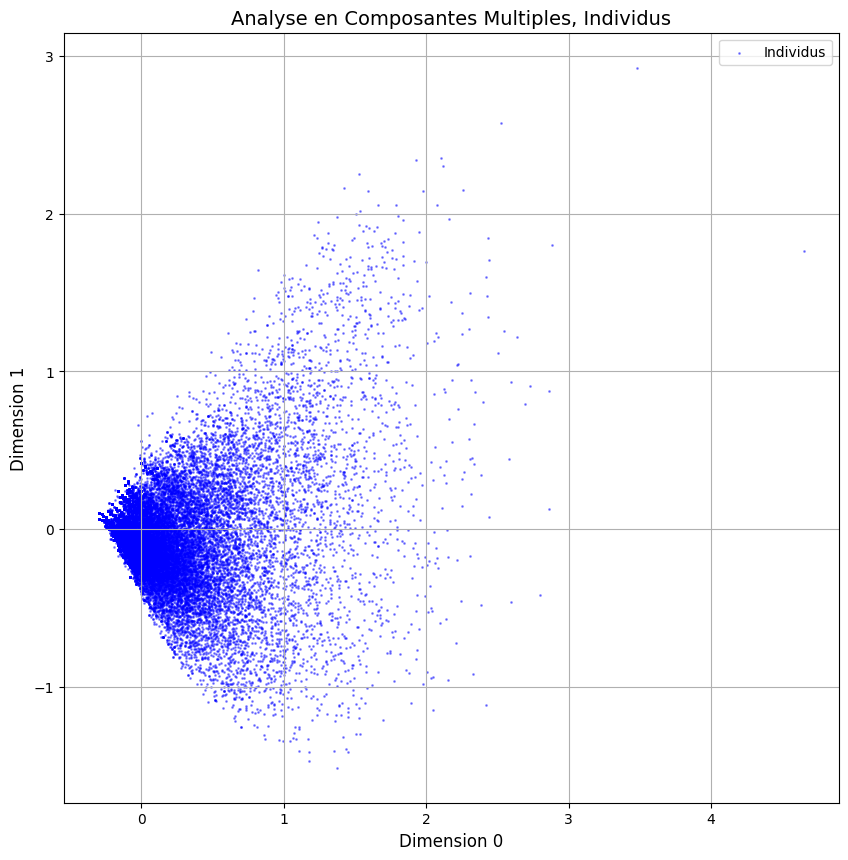

In [33]:
plot_individus = ad.mca_plot_individuals(df_mca, mca)

In [34]:
# Visualisation par groupes
# Le dataframe comporte beaucoup de colonnes => difficile de plotter un graphe à la fois

# Ajouter un aspect interactif : l'utilisateur choisit la variable de regroupement qu'il souhaite

var_selector = widgets.Dropdown( # Dropdown : liste avec les options qui s'affiche en cliquant
    df_mca=widgets.fixed(df_mca),  # valeur fixée au préalable, l'utilisateur n'a pas de choix
    mca=widgets.fixed(mca), # valeur fixée au préalable, l'utilisateur n'a pas de choix
    guide = widgets.fixed(guide), # valeur fixée au préalable, l'utilisateur n'a pas de choix
    options=df_mca.columns, # Variable à choisir
    description='Variable:',
    value='BREATHING' # la valeur par défaut
)

interactive_plot = widgets.interactive(ad.mca_plot_individuals_group, # la fonction prend 4 paramètres
                    variable=var_selector,
                    df_mca=widgets.fixed(df_mca),
                    mca=widgets.fixed(mca),
                    guide = widgets.fixed(guide))

display(interactive_plot)

interactive(children=(Dropdown(description='Variable:', options=('BREATHING', 'STOMACH', 'TOOTHACHES', 'CAVITI…

Le graphique des modalités issues de l’Analyse des Correspondances Multiples (MCA) permet de visualiser la contribution des différentes variables à la structuration des deux premières dimensions factorielles. Le graphique a été découpé en deux, avec un zoom sur les modalités concentrées au centre, à cause d'un manque de lisibilité.

De façon générale, cette analyse n'est pas extrêmement satisfaisante en raison de modalités très proches qui se chevauchent et d'individus qui se retrouvent extrêmement concentrés sur un plan 2D.

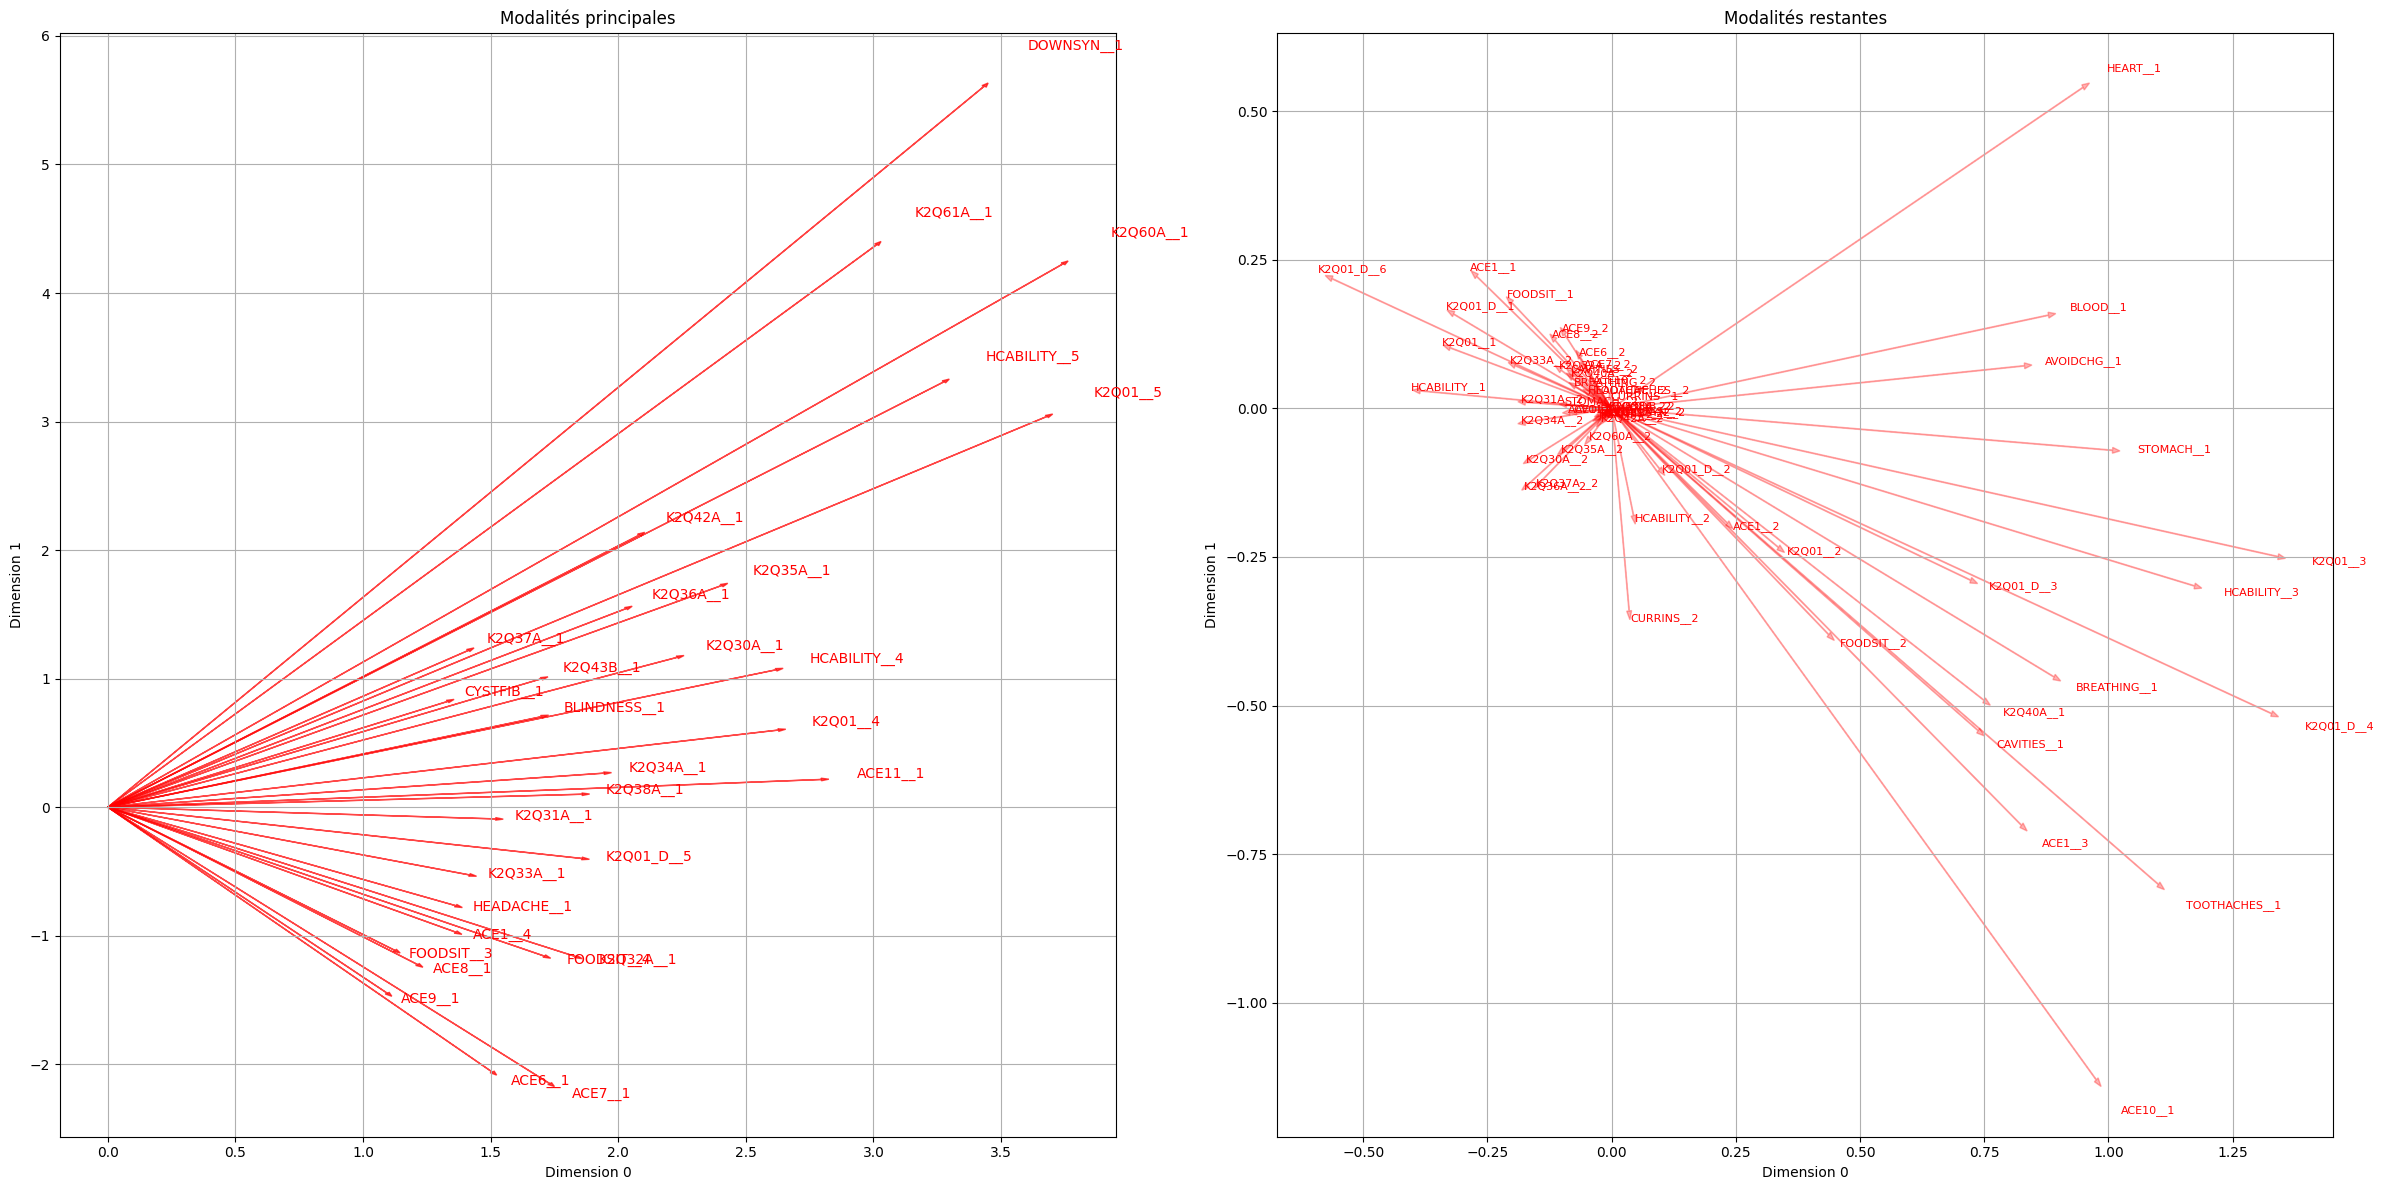

In [35]:
plot_modalites = ad.mca_plot_categories(df_mca, mca, 30)

Le heatmap met en évidence une structure globale marquée par des corrélations faibles à modérées entre la majorité des variables. La prédominance de teintes bleu clair à bleu moyen indique que, dans l’ensemble, les relations linéaires entre indicateurs restent limitées, sans dépendances fortes.

On observe toutefois quelques îlots de corrélations positives plus élevées, matérialisés par des zones rouge-orangées, suggérant l’existence de sous-groupes de variables plus étroitement associées. Ces regroupements apparaissent notamment autour de variables liées aux expériences adverses de l’enfance (ACE 6/7/8/9) et à certains diagnostics ou limitations de santé.

Un ensemble de corrélations plus fortes apparaît plus bas dans la matrice, autour de FOODSIT (capacité du ménage à se procurer suffisamment de nourriture) et ACE1 (difficulté à couvrir les besoins essentiels comme l’alimentation ou le logement).

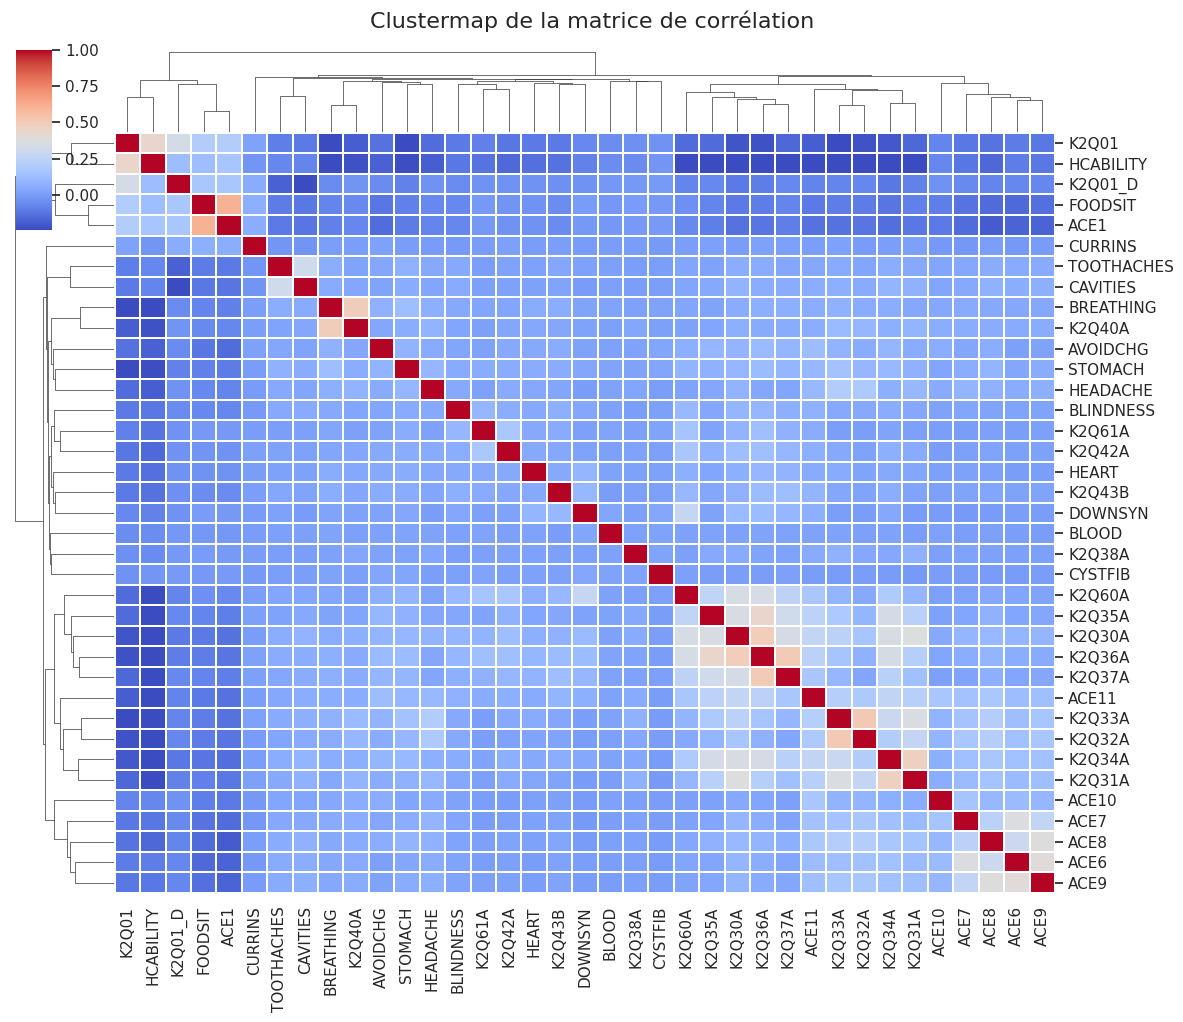

In [36]:
ad.heatmap_generator(df_mca)

## Enrichissement de la base de données

In [37]:
# Enrichissement avec la jointure entre la base économique et la base géographique

df_eco_geo = cd.clean_enrichment_datasets(gdp, gdf)

Dans cette nouvelle base de données économiques, nous remarquons six colonnes vides pour les données de 2024. Le reste de la base ne présente aucune valeur manquante.

### Colonnes manquantes pour 2024
1. `Implicit regional price deflator`
2. `Real PCE (millions of constant (2017) dollars)`
3. `Regional price parities (RPPs)`
4. `Real per capita personal income`
5. `Real personal income (millions of constant (2017) dollars)`
6. `Real per capita PCE`

Suite à l'absence du déflateur des prix au niveau des États, certaines variables ne sont pas calculables. Cela arrive surtout dans les bases de données locales ou régionales, où certains indicateurs ne sont pas systématiquement rapportés.

### Colonnes présentes pour 2024
1. Disposable personal income
2. Personal consumption expenditures
3. Per capita personal income
4. Per capita personal consumption expenditures (PCE)
5. Per capita disposable personal income
6. Gross domestic product (GDP)
7. Real GDP (millions of chained 2017 dollars)
8. Personal income
9. Total employment (number of jobs)


In [38]:
missing_values = df_eco_geo.isna().mean().sort_values(ascending=False) * 100
print(missing_values[:10])

2024_Real per capita personal income 4/                               100.0
2024_Real personal income (millions of constant (2017) dollars) 2/    100.0
2024_Real PCE (millions of constant (2017) dollars) 3/                100.0
2024_Real per capita PCE 5/                                           100.0
2024_Regional price parities (RPPs) 9/                                100.0
2024_Implicit regional price deflator 10/                             100.0
2018_Per capita personal consumption expenditures (PCE) 8/              0.0
2018_Per capita disposable personal income 7/                           0.0
2018_Personal consumption expenditures                                  0.0
2018_Personal income                                                    0.0
dtype: float64


# Création d'un indice synthétique annuel de santé au niveau des états

Afin de construire un indice synthétique de santé globale au niveau des états américains, nous allons adopter une méthodologie similaire à celle employée pour calculer l'Indice de Développement Humain. Nous allons calculer 3 sous-indicateurs pour chaque état : un indicateur maladies, un indicateur santé mentale et un indicateur économie-santé. Notre indice de santé globale sera calculé comme la moyenne géométrique de ces 3 indicateurs.

Nos sous-indicateurs seront une moyenne pondérée de ces variables. Afin de construire notre indicateur, notre idée initiale était de réaliser une ACP sur nos variables agrégées par état, et choisir comme
pondération les charges factorielles de chaque variable, i.e la contribution de chaque variable à la première composante de l'ACP. Ce choix est motivé par un désir de choisir une pondération issue des données afin d'éviter une pondération arbitraire. Cependant, comme nous le verrons plus bas, l'ACP ne donne pas de résultats satisfaisants (avec une première composante qui n'explique qu'un quart de la variance expliquée). Nous nous rabattons donc pour éviter de faire des choix plus arbitraires sur une moyenne simple des variables.

## Indicateur pour les maladies : illustration sur l'année 2023

Pour les maladies, nous avons volontairement choisi d'utiliser uniquement les questions sous la forme "Has a doctor or other health care provider EVER told you that this child has..." afin de simplifier l'étude.
Pour construire nos indicateurs, nous agrégeons ces variables par état grâce à la variable FIPSST.
Notre nouvelle base de données sera une base où les individus seront chaque état, avec les variables ci-dessus en moyenne.
Pour construire un indicateur pertinent (plus l'indicateur est grand, plus la population est saine), on inversera le sens des catégories pour General Health et Teeth description (donc 1 = Poor à 5 = Excellent pour General Health, 0 = Pas de dents (enfant trop petit) à 5 = Excellent pour Teeth description). De même, pour une question de lisibilité, on a remplacé pour les variables binaires 1/2 par 0/1, avec 0 = a la maladie, 1 = ne l'a pas.

In [39]:
df_2021, df_2022, df_2023, df_2024 = (
    dfs_final[str(year)] for year in range(2021, 2025)
)

groups = {"FIPSST", "FWC"}
health_total_vars = list(set(health_vars) | set(groups))

# étape n°1 : Inversion de l'échelle
df_sickness_2023 = df_2023[health_total_vars].copy()
df_sickness_2023[health_category_vars] = 6 - df_sickness_2023[health_category_vars]

# étape n°2 : Inversion des variables binaires
# Transformation : sain = 1, malade = 0
for var in health_bin_vars:
    df_sickness_2023[var] = df_sickness_2023[var] - 1

General Health capture la perception par les parents de la santé de leur enfant. On propose de régresser cette variable sur des variables objectives de santé pour tester sa pertinence. 

Toutes les variables sont statistiquement significatives. Tous les coefficients sont positifs ce qui signifie que ne pas présenter un trouble ou une maladie (1) augmente la perception de la santé. Cette variable semble donc être pertinente.

In [40]:
# Définir y et X
y = df_sickness_2023['K2Q01']
X = df_sickness_2023[["K2Q40A", "K2Q42A", "K2Q43B", "K2Q61A", "BLINDNESS", 
                       "BLOOD", "BREATHING", "CAVITIES", "CYSTFIB", "HEADACHE", 
                       "HEART", "STOMACH", "TOOTHACHES"]]

# Ajouter une constante pour l'intercept
X = sm.add_constant(X)

# Créer le modèle OLS et ajuster
model_ols = sm.OLS(y, X)
res = model_ols.fit()

results_ols = pd.DataFrame({
    "Variable": res.params.index,
    "Coefficient": res.params.values,
    "Std Error": res.bse,
    "t-value": res.tvalues,
    "p-value": res.pvalues
})

# Trier par valeur absolue du coefficient si besoin
results_ols = results_ols.reindex(results_ols["Coefficient"].abs().sort_values(ascending=False).index)

# Afficher
print(results_ols)


              Variable  Coefficient  Std Error    t-value        p-value
K2Q61A          K2Q61A     0.551567   0.053536  10.302830   7.206804e-25
K2Q42A          K2Q42A     0.521766   0.027999  18.634980   2.891097e-77
CYSTFIB        CYSTFIB     0.476949   0.114644   4.160275   3.183450e-05
STOMACH        STOMACH     0.454894   0.009901  45.944048   0.000000e+00
BREATHING    BREATHING     0.423312   0.011714  36.137417  1.198981e-282
K2Q43B          K2Q43B     0.417238   0.024575  16.977998   1.743756e-64
BLINDNESS    BLINDNESS     0.387406   0.024645  15.719260   1.474209e-55
HEADACHE      HEADACHE     0.378057   0.015366  24.604050  5.980376e-133
BLOOD            BLOOD     0.316232   0.038302   8.256233   1.536343e-16
HEART            HEART     0.286227   0.017010  16.826549   2.245574e-63
K2Q40A          K2Q40A     0.176080   0.010483  16.796909   3.693068e-63
CAVITIES      CAVITIES     0.158343   0.009585  16.519280   3.741051e-61
TOOTHACHES  TOOTHACHES     0.139308   0.016584   8.

In [41]:
# Agrégation par état
def weighted_mean(x, w):
    return (x * w).sum() / w.sum()

df_sickness_state_2023 = df_sickness_2023.groupby("FIPSST")[health_vars + ["FWC"]].apply(
    lambda g: pd.Series({var: weighted_mean(g[var], g["FWC"]) for var in health_vars}))

In [42]:
X = df_sickness_state_2023[health_vars]

In [43]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=health_vars, index=df_sickness_state_2023.index)

In [44]:
pca = PCA()
pca.fit(X_std)

explained_variance = pca.explained_variance_ratio_
print("Variance expliquée par PC1 :", explained_variance[0])

Variance expliquée par PC1 : 0.20424224600381502


Nous obtenons une première composante expliquant une part de la variance assez faible, seulement 22% (il aura fallu au moins 4 composantes pour expliquer plus de 50% de la variance). La pondération que nous pouvons en extraire ne présentera donc pas d'avantages comparé à une pondération arbitraire comme une pondération uniforme. Nous choisissons donc une pondération uniforme pour notre indicateur.

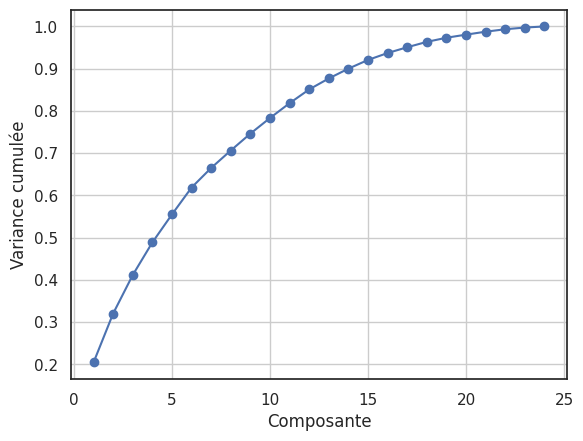

In [45]:
plt.plot(range(1, len(explained_variance)+1), explained_variance.cumsum(), marker='o')
plt.xlabel("Composante")
plt.ylabel("Variance cumulée")
plt.grid()
plt.show()

In [46]:
df_sickness_state_2023["sub_indicator_health_2023"] = X.mean(axis=1)

In [47]:
df_sickness_state_2023["sub_indicator_health_2023"].describe()

count    51.000000
mean      1.234189
std       0.007482
min       1.217147
25%       1.228206
50%       1.235238
75%       1.239912
max       1.247054
Name: sub_indicator_health_2023, dtype: float64

Notre indicateur peut prendre des valeurs comprises entre 1/24 = 0.042 (cas où toutes les variables sont au minimum) et 32/24 = 1.333 (en l'occurrence ici, l'indicateur est compris entre 1.3 et 1.42 pour les états américains). Nous effectuons une transformation affine, pour le ramener entre 0 et 1 (de façon similaire aux sous-indices utilisés pour le calcul de l'indice de développement humain).

In [48]:
I = df_sickness_state_2023["sub_indicator_health_2023"]

df_sickness_state_2023["sub_indicator_health_2023"] = (I-1/24)/(32/24 - 1/24)
df_sickness_state_2023["sub_indicator_health_2023"].describe()

count    51.000000
mean      0.923243
std       0.005792
min       0.910049
25%       0.918611
50%       0.924055
75%       0.927674
max       0.933203
Name: sub_indicator_health_2023, dtype: float64

Les valeurs sont très concentrées autour de la moyenne. Même les valeurs extrêmes restent proches du centre, ce qui confirme une faible variabilité globale.

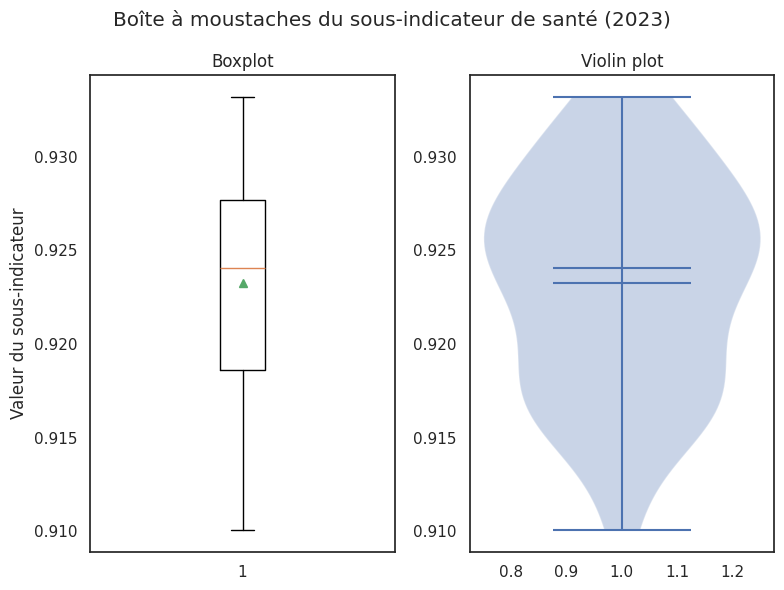

In [49]:
ad.boxplot_image("Boîte à moustaches du sous-indicateur de santé (2023)",
                 "Valeur du sous-indicateur",
                 df_sickness_state_2023["sub_indicator_health_2023"])

## Indicateur pour la santé mentale : illustration sur l'année 2023

In [50]:
mental_heath_indicator_2023 = model.calculate_indicator("2023", dfs_final, "mental_health", 
                                             mental_category_vars, mental_bin_vars,
                                             groups)

In [51]:
mental_heath_indicator_2023.describe()

count    51.000000
mean      0.911450
std       0.010795
min       0.887360
25%       0.903238
50%       0.911411
75%       0.919367
max       0.937223
Name: sub_indicator_mental_health_2023, dtype: float64

Les valeurs sont très concentrées autour de la moyenne. Même les valeurs extrêmes restent proches du centre, ce qui confirme une faible variabilité globale.

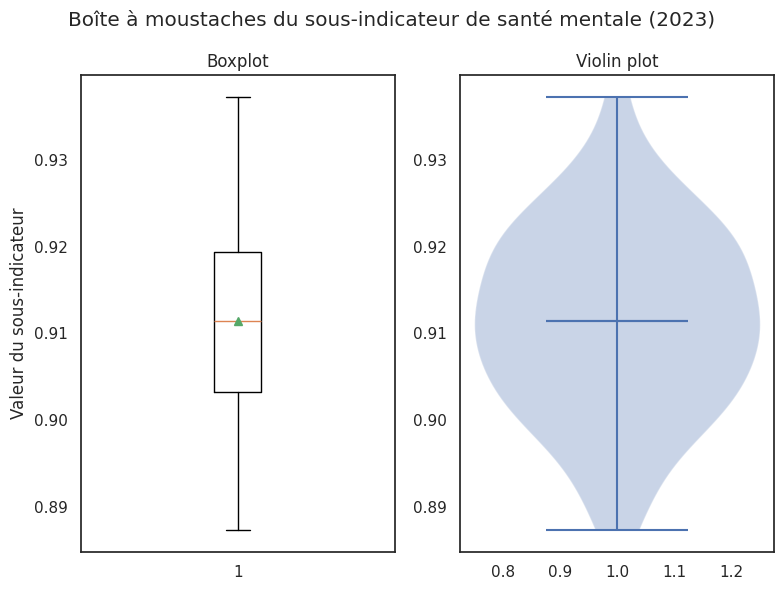

In [52]:
ad.boxplot_image("Boîte à moustaches du sous-indicateur de santé mentale (2023)",
                 "Valeur du sous-indicateur",
                 mental_heath_indicator_2023)

## Indicateur santé-économie : illustration pour l'année 2023

In [53]:
df_eco_geo_indic = cd.clean_eco_data(df_eco_geo)

Nous travaillons en premier lieu sur les 4 variables du survey NSCH, afin de les agréger à l'échelle de l'état, pour ensuite faire la jointure avec les données macroéconomiques.

De nouveau, on change CURRINS en une variable binaire 0/1, de telle sens que 1 = Yes, comme c'est une issue positive (et comme notre indicateur sera une moyenne des variables, donc une fonction croissante en les variables, on veut bien que plus une variable représente une issue, positive au niveau santé, plus l'indicateur est haut). De même pour les variables catégorielles.

In [54]:
NSCH_eco_vars = NSCH_eco_bin_vars + NSCH_eco_cat_vars
NSCH_eco_total_vars = ["FIPSST", "FWC"] + NSCH_eco_vars

df_health_eco_2023 = df_2023[NSCH_eco_total_vars]

# .copy() -- éviter des problèmes de pandas
df_health_eco_2023 = df_health_eco_2023.copy()
df_health_eco_2023[NSCH_eco_cat_vars] = 5 - df_health_eco_2023[NSCH_eco_cat_vars]

# CURRINS = abs(CURRINS - 2), de telle sorte que 2 soit envoyé sur 0, et 1 va rester à 1
df_health_eco_2023["CURRINS"] = abs(df_health_eco_2023["CURRINS"] - 2)
# de meme pour AVOIDCHG
df_health_eco_2023["AVOIDCHG"] = abs(df_health_eco_2023["AVOIDCHG"] - 2)

# après le groupby : préciser les colonnes pour éviter des soucis sur la mise à jour du pandas
df_health_eco_state_2023 = df_health_eco_2023.groupby("FIPSST")[NSCH_eco_vars + ["FWC"]].apply(
    lambda g: pd.Series({var: weighted_mean(g[var], g["FWC"]) for var in NSCH_eco_vars})
)

De plus, ici, on a 9 variables macroéconomiques contre 4 variables "microéconomiques" liées à la santé, l'assurance et au fait de pouvoir subvenir aux besoins de l'enfant.
Pour éviter une prédominance des variables macroéconomiques dans la moyenne, on réalise d'abord la moyenne sur les variables du NSCH d'une part, et d'autre part, la moyenne sur les variables macros, puis on construira notre indicateur comme moyenne de ces deux moyennes.

In [55]:
X = df_health_eco_state_2023[NSCH_eco_vars]
df_health_eco_state_2023["sub_indicator_microeco_2023"] = X.mean(axis=1)

I = df_health_eco_state_2023["sub_indicator_microeco_2023"]
df_health_eco_state_2023["sub_indicator_microeco_2023"] = (I-1/2)/(10/4 - 1/2)

In [56]:
eco_templates = [
    "Disposable personal income",
    "Gross domestic product (GDP)",
    "Per capita disposable personal income 7/",
    "Per capita personal consumption expenditures (PCE) 8/",
    "Per capita personal income 6/",
    "Personal consumption expenditures",
    "Personal income",
    "Real GDP (millions of chained 2017 dollars) 1/",
    "Total employment (number of jobs)"
]

state_eco_vars_dict = {
    "2021": [f"2021_{var}" for var in eco_templates],
    "2022": [f"2022_{var}" for var in eco_templates],
    "2023": [f"2023_{var}" for var in eco_templates],
    "2024": [f"2024_{var}" for var in eco_templates],
}

state_eco_vars_2023 = state_eco_vars_dict["2023"]


In [57]:
# On peut maintenant faire la même étude sur les variables macroéconomiques
df_macro_state_2023 = df_eco_geo_indic[["FIPSST"] + state_eco_vars_2023].copy()
X = df_macro_state_2023[state_eco_vars_2023]

scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=state_eco_vars_2023, index=df_macro_state_2023.index)

pca = PCA()
pca.fit(X_std)

explained_variance = pca.explained_variance_ratio_
print("Variance expliquée par PC1 :", explained_variance[0])

Variance expliquée par PC1 : 0.6843998608968528


In [58]:
loadings = pca.components_[0]
weights_raw = abs(loadings)
weights = weights_raw / weights_raw.sum()
df_macro_state_2023["sub_indicator_macroeco_2023"] = (X_std * weights).sum(axis=1)

# Afin de se ramener à des valeurs entre 0 et 1
# on normalise notre indicateur et on effectue la transformation I <- F(I) 
# où F est la fonction de répartition de la loi normale standard.

std_indic = (
    df_macro_state_2023["sub_indicator_macroeco_2023"] - df_macro_state_2023["sub_indicator_macroeco_2023"].mean()
) / df_macro_state_2023["sub_indicator_macroeco_2023"].std()

df_macro_state_2023["sub_indicator_macroeco_2023"] = norm.cdf(std_indic)

On calcule enfin le sous-indicateur santé-économie final comme moyenne des deux.

In [59]:
df_macro_state_2023["FIPSST"] = pd.to_numeric(df_macro_state_2023["FIPSST"], errors="coerce")

df_eco_2023 = df_macro_state_2023.merge(df_health_eco_state_2023, on="FIPSST", how="inner")
df_eco_2023.set_index("FIPSST", inplace=True)
df_eco_2023["sub_indicator_eco_2023"] = (df_eco_2023["sub_indicator_macroeco_2023"] + df_eco_2023["sub_indicator_microeco_2023"])/2

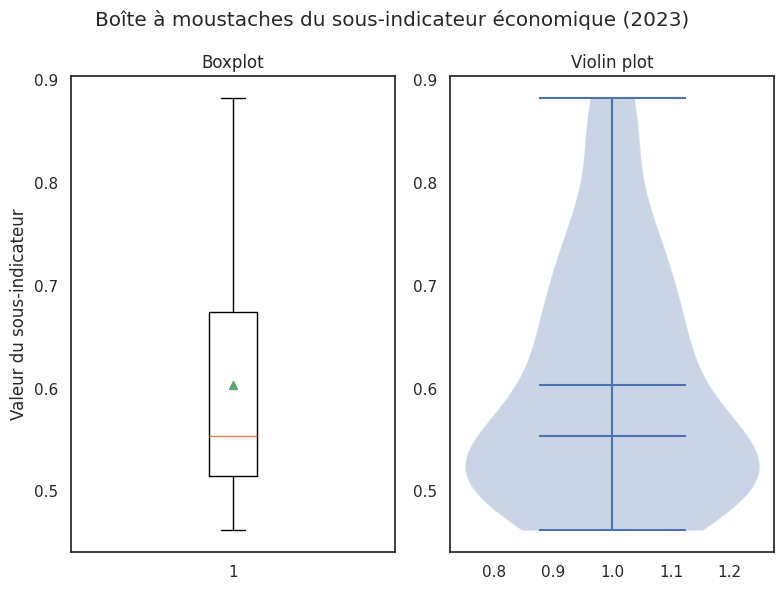

In [60]:
ad.boxplot_image("Boîte à moustaches du sous-indicateur économique (2023)",
                 "Valeur du sous-indicateur",
                 df_eco_2023["sub_indicator_eco_2023"])

## Indicateur final pour l'année 2023

In [61]:
mental_heath_indicator_2023 = mental_heath_indicator_2023.to_frame(name="sub_indicator_mental_2023")
mental_2023 = mental_heath_indicator_2023[["sub_indicator_mental_2023"]]
health_2023 = df_sickness_state_2023[["sub_indicator_health_2023"]]
eco_2023 = df_eco_2023[["sub_indicator_eco_2023"]]

df_final = (
    mental_2023
    .join(health_2023, how="inner")
    .join(eco_2023, how="inner")
)

df_final["indicator_global_health_2023"] = (df_final["sub_indicator_mental_2023"]* df_final["sub_indicator_health_2023"] * df_final["sub_indicator_eco_2023"])**(1/3)

In [62]:
df_final["indicator_global_health_2023"].describe()

count    51.000000
mean      0.794965
std       0.050901
min       0.728449
25%       0.754390
50%       0.775680
75%       0.829968
max       0.912142
Name: indicator_global_health_2023, dtype: float64

L'indicateur global est plus étalé, se situant approximativement dans l'intervalle [0,7 ; 0,9], avec des valeurs davantage regroupées vers le bas de la distribution.

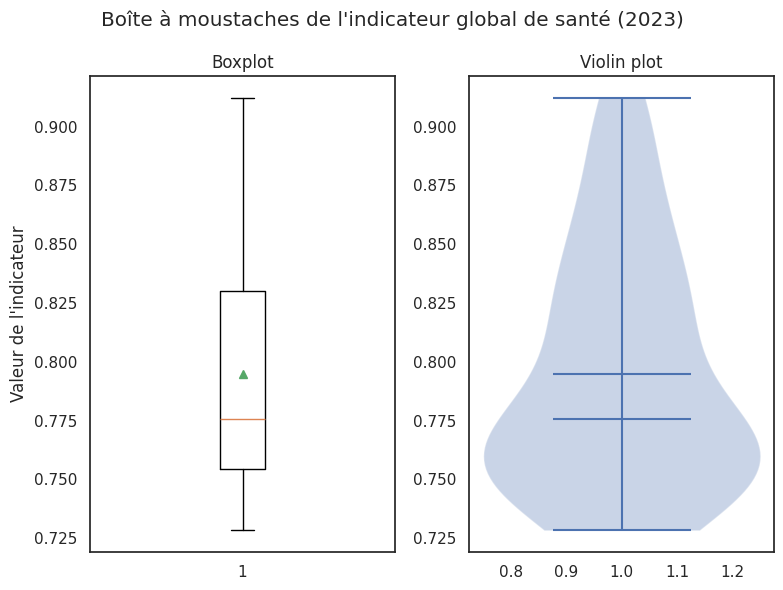

In [63]:
ad.boxplot_image("Boîte à moustaches de l'indicateur global de santé (2023)",
                 "Valeur de l'indicateur",
                 df_final["indicator_global_health_2023"])

## Construction des sous-indicateurs et de l'indicateur sur quatre années

In [64]:
df_global_indicator = model.global_health_over_years(
    years = ["2024", "2023", "2022", "2021"],
    df_eco = df_eco_geo_indic, 
    dfs = dfs_final, 
    groups = {"FIPSST", "FWC"},
    mental_category_vars = mental_category_vars, 
    mental_bin_vars = mental_bin_vars,
    health_category_vars = health_category_vars, 
    health_bin_vars = health_bin_vars,
    NSCH_eco_cat_vars = NSCH_eco_cat_vars, 
    NSCH_eco_bin_vars = NSCH_eco_bin_vars,
    state_eco_vars_dict = state_eco_vars_dict)


Dans la construction de cet indicateur, on craignait que l'un des sous-indicateurs « impose » le classement des États. On effectue un test de Kendall sur les classements générés, pour une année, par chacun des sous-indicateurs ainsi que par l'indicateur global. Il existe une corrélation, mais peu marquée, entre l'indicateur global et sa sous-composante économique.

In [65]:
kendall_test = ad.kendall_analysis(df_global_indicator)
kendall_test

,Year,Sub_indicator,Kendall_tau
0,2024,sub_indicator_eco,0.416471
1,2024,sub_indicator_health,-0.072941
2,2024,sub_indicator_mental,-0.135686
3,2023,sub_indicator_eco,0.598431
4,2023,sub_indicator_health,0.077647
5,2023,sub_indicator_mental,0.115294
6,2022,sub_indicator_eco,0.396078
7,2022,sub_indicator_health,0.120000
8,2022,sub_indicator_mental,0.234510
9,2021,sub_indicator_eco,0.320784


# Carte interactive des indicateurs de santé aux États-Unis (Folium)

Via une carte interactive, on visualise les indicateurs au niveau de chaque État. Visuellement, les États en meilleure santé se situent sur la côte Est des États-Unis (New York, Pennsylvanie). On observe également une validation de la première loi de la géographie de Waldo Tobler : « Tout est lié à tout le reste, mais les choses proches sont plus liées que les choses éloignées. » Effectivement, sur la côte Est, plusieurs États en « bonne santé » sont des voisins, tandis que la santé se dégrade petit à petit vers le centre des États-Unis.

In [66]:
ad.interactive_map(df_global_indicator, df_eco_geo)

Dropdown(description='Année:', index=3, options=('2021', '2022', '2023', '2024'), value='2024')

Output()

Au fil des années, nous n’observons pas de grands gains ou pertes dans le classement généré par l’indicateur global. Les États qui étaient en très bonne santé au début de 2021 le sont toujours en 2024, et il en va de même pour les États les moins bien classés. Certains États ont cependant connu des variations plus importantes, comme Rhode Island, qui a gagné 5 places entre 2023 et 2024, ou à l’inverse South Dakota, qui en a perdu 7 sur la même période.

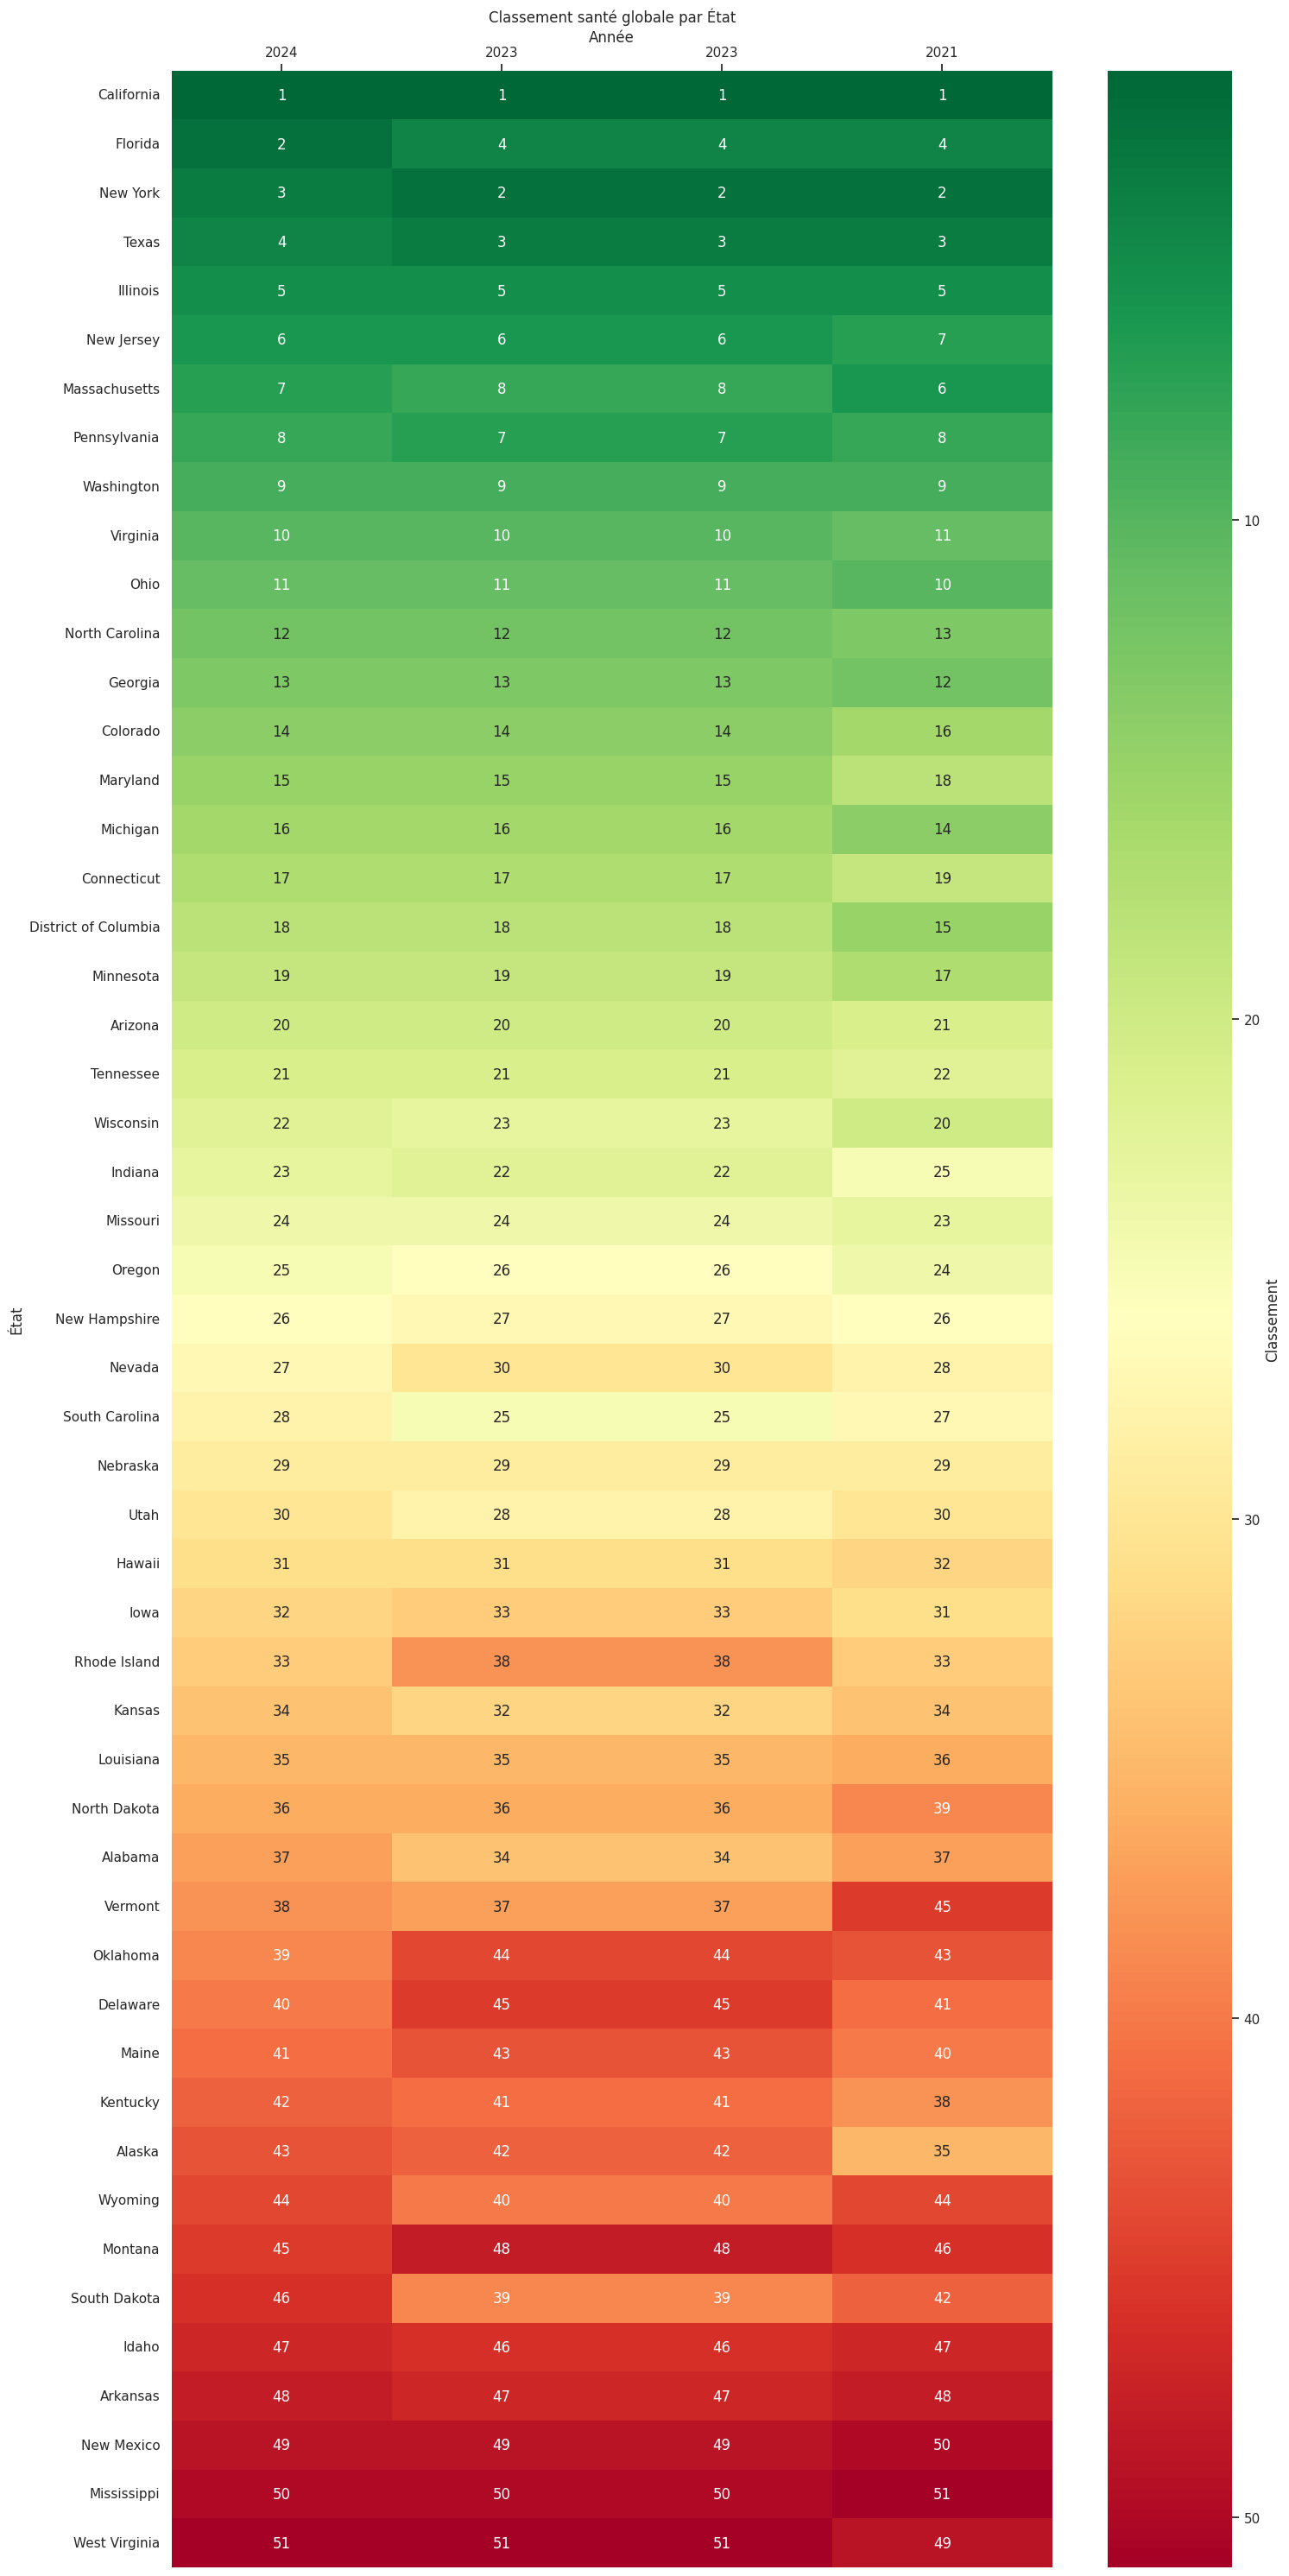

In [67]:
ad.state_rankings(df_global_indicator, df_eco_geo)

# Comparaison avec un autre indicateur de santé par État

Pour estimer la pertinence de l'indicateur de santé infantile que nous avons construit, nous le comparons avec un indicateur de santé général, qui concerne les adultes aussi bien que les enfants, construit par la United Health Fondation ([lien](https://www.americashealthrankings.org/publications/articles/state-rankings-since-1990)). Ce dernier inclut une cinquantaine de variables, réunies dans cinq catégories : "Social and Economic Factors", "Physical Environment", "Behaviors", "Clinical Care" and "Health Outcomes". La United Health Fondation construit un indicateur par catégorie et calcule l'indicateur global en faisant la moyenne pondérée des sous-indicateurs. Les catégories qu'ils pondèrent le plus sont "Health Outcomes" et "Social Economic Factors". Les indicateurs sont calculés par État. 

In [68]:
# aperçu de la base de données
annual_report.head(5)

,Report,Measure,State,Value,Score,Rank,LowerCI,UpperCI,Source,Data Year(s)
0,2024 Annual,Social and Economic Factors,AK,0.042,0.042,30.0,NaN,NaN,America's Health Rankings composite measure,2024
1,2024 Annual,Social and Economic Factors,AL,-0.542,-0.542,43.0,NaN,NaN,America's Health Rankings composite measure,2024
2,2024 Annual,Social and Economic Factors,ALL,NaN,NaN,NaN,NaN,NaN,America's Health Rankings composite measure,2024
3,2024 Annual,Social and Economic Factors,AR,-0.971,-0.971,47.0,NaN,NaN,America's Health Rankings composite measure,2024
4,2024 Annual,Social and Economic Factors,AZ,0.053,0.053,29.0,NaN,NaN,America's Health Rankings composite measure,2024


Nous recalculons l'indicateur général par État à partir des sous-indicateurs par catégorie déjà fournis dans le fichier csv de la United Health Fondation. L'objectif est d'obtenir un tableau avec, pour chaque État, l'indicateur de santé infantile que nous avons construit dans ce projet (indicator_global_health_2024) et l'indicateur général de santé de la United Health Fondation (global_indicator_UHF).

In [69]:
df_final = model.comparison_new_indicator(annual_report, df_global_indicator, df_eco_geo)

Pour comparer le classement donné par notre indicateur et celui donné par l'indicateur de la United Health Fondation, nous utilisons le tau de Kendall. Le tau de Kendall mesure l’association entre deux classements en comparant toutes les paires d’observations : une paire est dite concordante si l’ordre est le même dans les deux classements, discordante sinon. Le coefficient est calculé comme la différence entre le nombre de paires concordantes et discordantes, rapportée au nombre total de paires (avec des ajustements possibles en cas d’ex æquo). Il varie entre −1 (classements opposés) et +1 (classements identiques). Son principal intérêt est qu’il ne dépend que des rangs : il permet donc de comparer deux classements même lorsque les variables sont mesurées sur des échelles différentes ou non linéaires, et il est robuste aux valeurs extrêmes.

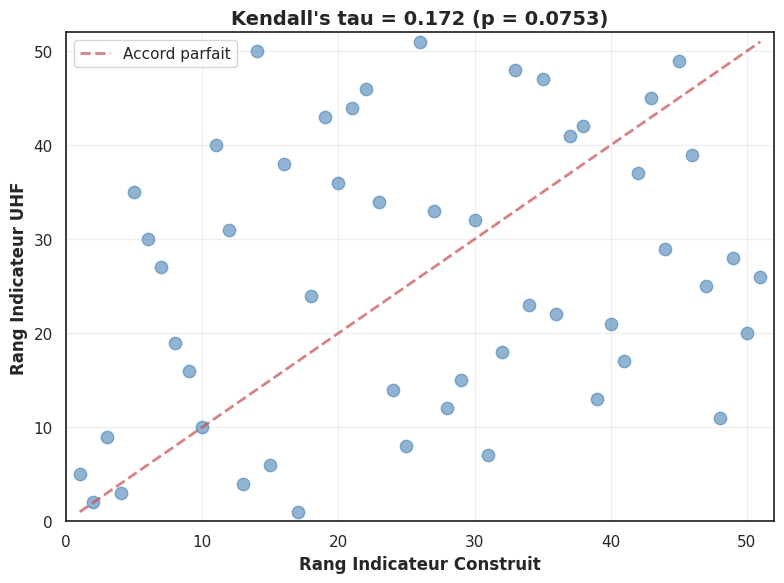

Kendall's tau = 0.172 (p = 0.0753)


In [70]:
# Calcul du Kendall's tau
tau, p_value = kendalltau(df_final['indicator_global_health_2024'], 
                          df_final['global_indicator_UHF'])

# Calcul des rangs
rank_2024 = df_final['indicator_global_health_2024'].rank()
rank_recalc = df_final['global_indicator_UHF'].rank()

# Visualisation
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(rank_2024, rank_recalc, alpha=0.6, s=80, color='steelblue')
ax.plot([1, 51], [1, 51], 'r--', linewidth=2, label='Accord parfait', alpha=0.7)
ax.set_xlabel('Rang Indicateur Construit', fontsize=12, fontweight='bold')
ax.set_ylabel('Rang Indicateur UHF', fontsize=12, fontweight='bold')
ax.set_title(f"Kendall's tau = {tau:.3f} (p = {p_value:.4f})", 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 52)
ax.set_ylim(0, 52)

plt.tight_layout()
plt.show()

print(f"Kendall's tau = {tau:.3f} (p = {p_value:.4f})")

La grande dispersion des points sur le graphique et la faiblesse du tau de Kendall (0.172) et une p-value qui nous permet de rejeter l'hypothèse nulle (Il n’existe aucune association monotone entre les deux variables) montre que les indicateurs donnent des classements faiblement corrélés. Cette différence peut s'expliquer par des choix de variables ou de pondération différents. Par ailleurs, nous comparons différentes régions d'un pays très développé où, en comparaison au reste du monde, les dépenses de santé sont élevées à peu près partout. Si nous comparions des pays avec des PIB très différents, nous devrions obtenir des classements similaires avec les deux indicateurs.

Il ne nous semble pas pertinent de régresser un indicateur sur un autre car le calcul du tau de Kendall et la visualisation des classements dans l'espace invalident l'hypothèse d'une relation linéaire entre les deux indicateurs.

## Régression linéaire sur les sous-indicateurs

Le sous-indicateur santé est le facteur majeur qui influence l'indicateur UHF. Les sous-indicateurs mental et économique ne sont pas significatifs ici.

In [71]:
df_final["scaled_ind"] = (df_final["global_indicator_UHF"] + 1)/2

# Variables 
X = df_final[["sub_indicator_health_2024",
            "sub_indicator_mental_2024", "sub_indicator_eco_2024"]]

X = sm.add_constant(X)

y = df_final["scaled_ind"]

model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             scaled_ind   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     13.40
Date:                Mon, 29 Dec 2025   Prob (F-statistic):           1.90e-06
Time:                        13:30:49   Log-Likelihood:                 18.447
No. Observations:                  51   AIC:                            -28.89
Df Residuals:                      47   BIC:                            -21.17
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 